# Instagram Dataset
https://www.kaggle.com/free4ever1/instagram-fake-spammer-genuine-accounts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.regularizers import l1
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import import_ipynb
from functions import *
from time import time

importing Jupyter notebook from functions.ipynb


In [2]:
file1 = pd.read_csv('data/instagram1.csv', header=0)
file2 = pd.read_csv('data/instagram2.csv', header=0)

data = pd.concat([file1, file2])
data

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0
...,...,...,...,...,...,...,...,...,...,...,...,...
571,1,0.55,1,0.44,0,0,0,0,33,166,596,1
572,1,0.38,1,0.33,0,21,0,0,44,66,75,1
573,1,0.57,2,0.00,0,0,0,0,4,96,339,1
574,1,0.57,1,0.00,0,11,0,0,0,57,73,1


## Data Evaluation
---

### Checking for null values

In [3]:
if data.isna().sum().sum() == 0:
    print('No missing values present')
else: 
    print('NaN values across entire dataset: ', data.isna().sum().sum())

No missing values present


### Heatmap
Feature Colliniearity
- *No significant multicolliniearity observed - L1 regularization ideal*

Text(0.5, 1.0, 'Instagram Dataset Colliniearity')

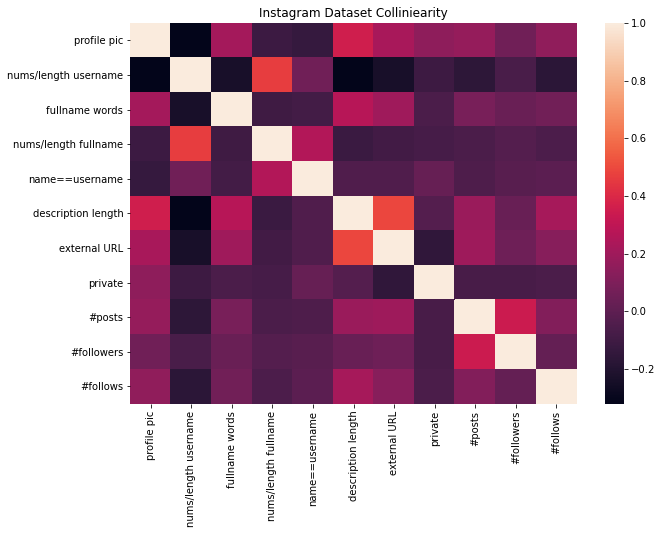

In [4]:
corr = data.loc[:, data.columns != 'fake'].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr)
plt.title('Instagram Dataset Colliniearity')

### Histogram
Feature Distributions

In [5]:
categorical = ['private', 'profile pic', 'name==username', 'external URL']
numerical = ['#followers', '#follows', '#posts', 'description length', 'fullname words', 'nums/length fullname', 'nums/length username']

Text(0.5, 0.92, 'Instagram Dataset Feature Distributions')

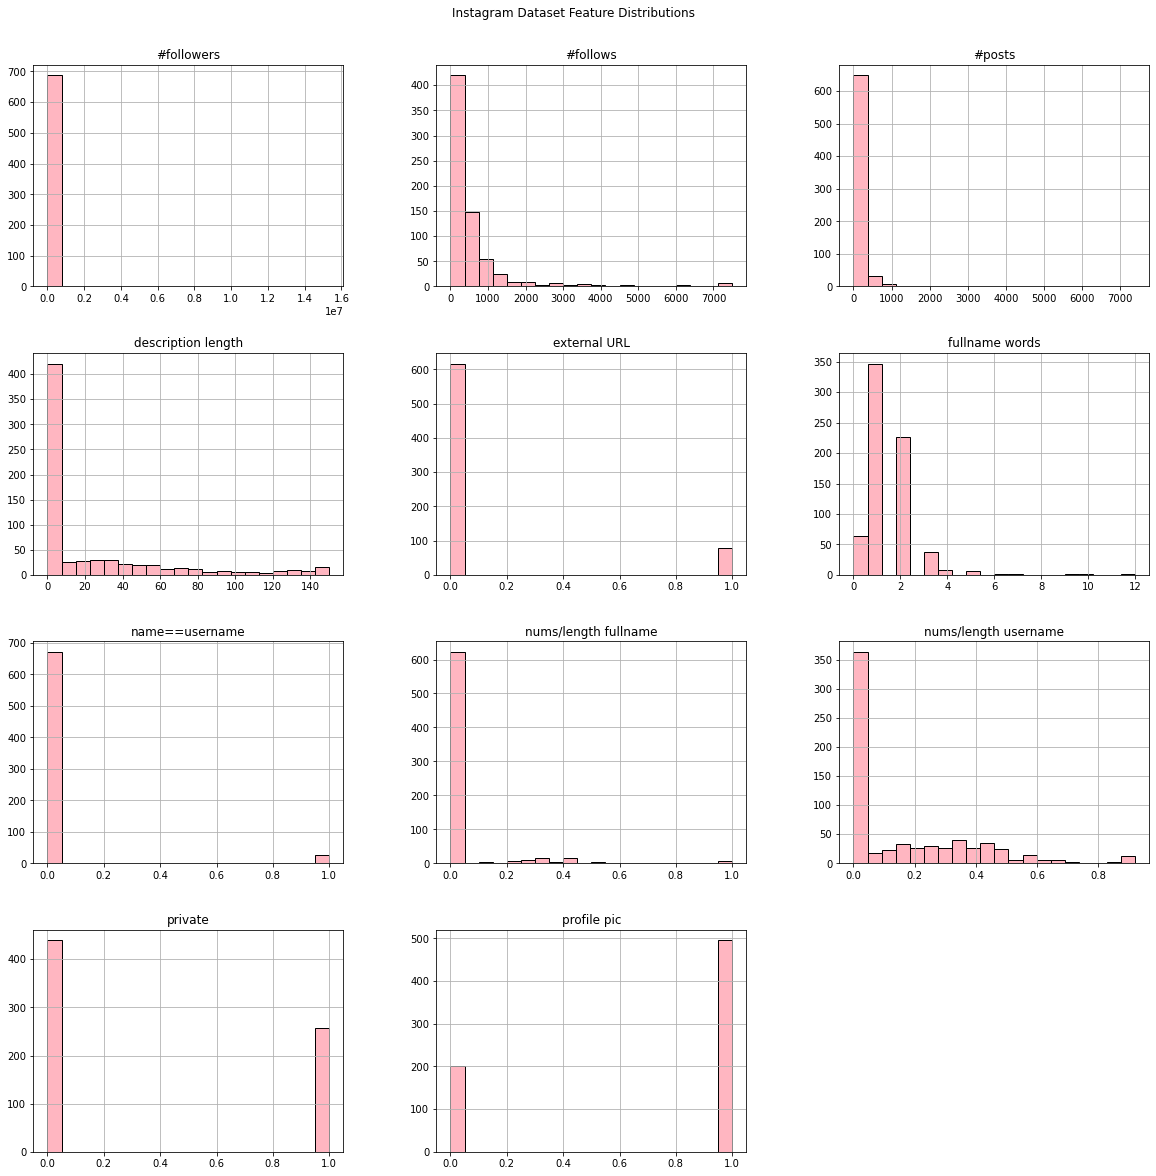

In [6]:
data.loc[:, data.columns != 'fake'].hist(bins=20, figsize=(20,20), color='lightpink', ec="black")
plt.suptitle('Instagram Dataset Feature Distributions', y=0.92)

### Pie Chart 
Class Balance
- *No class imbalance observed*

In [7]:
class_counts = data['fake'].value_counts()
class_counts

1    348
0    348
Name: fake, dtype: int64

Text(0.5, 1.05, 'Instagram Dataset Class Distribution')

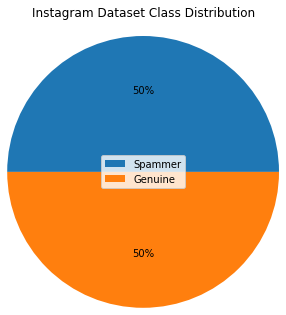

In [8]:
classes = ['Spammer', 'Genuine']
plt.figure(figsize=(5, 5))
plt.pie(class_counts, autopct='%1.0f%%', radius=1.25)
plt.legend(labels=classes, loc='center')
plt.title('Instagram Dataset Class Distribution', y=1.05)

## Data Preparation
---

In [9]:
#Train/test/val subsets
train, test = train_test_split(data, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)

In [10]:
#Separating labels from data
x_test, y_test = features_labels_split(test, 'fake')
x_train, y_train = features_labels_split(train, 'fake')
x_val, y_val = features_labels_split(val, 'fake')

In [12]:
#Scaling
scaler = preprocessing.MinMaxScaler() 

x_train = scaler.fit_transform(x_train) 
x_val = scaler.transform(x_val) 
x_test = scaler.transform(x_test) 

In [13]:
#Label one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [14]:
print(f'Total samples: {x_test.shape[0] + x_train.shape[0] + x_val.shape[0]}')
print(f'Testing samples: {x_test.shape[0]}') 
print(f'Training samples: {x_train.shape[0]}')
print(f'Validation samples {x_val.shape[0]}')

Total samples: 696
Testing samples: 70
Training samples: 563
Validation samples 63


## Model
---

In [90]:
#Define
model = Sequential()
model.add(Dense(units=16, input_dim=x_train.shape[1], activation='relu')) 
model.add(Dropout(0.1))
model.add(Dense(units=64, activation='relu')) 
model.add(Dense(units=128, activation='relu')) 
model.add(Dropout(0.1))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation="softmax"))

In [91]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 16)                192       
_________________________________________________________________
dropout_39 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_80 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_82 (Dense)             (None, 32)              

In [92]:
#Compile
model.compile(optimizer = Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [93]:
#Fit
start = time()

history = model.fit(x_train, 
                    y_train, 
                    validation_data = (x_val, y_val),
                    epochs=200, 
                    batch_size=10, 
                    verbose=0)

print(f'Complete. \nModel trained in {round(time()-start, 2)} sec')

Complete. 
Model trained in 13.45 sec


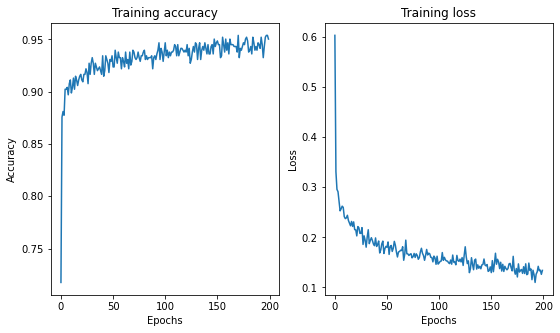


Training accuracy: 95.03%
Training loss: 0.134


In [94]:
plot_display_metrics(model, history)

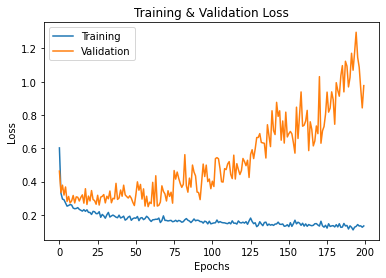


Training accuracy: 95.03%
Training loss: 0.134

Validation accuracy: 87.3%
Validation loss: 0.977


In [95]:
plot_train_val(history)

In [96]:
#Test
test_score = model.evaluate(x_test, y_test)
print(f"Testing accuracy: {round(test_score[1], 4) * 100}%")
print(f"Testing loss: {round(test_score[0], 3)}")

3/3 [==============================] - 0s 1ms/step - loss: 0.5406 - accuracy: 0.8714
Testing accuracy: 87.14%
Testing loss: 0.541


## Model Evaluation
---

### Confusion Matrix

In [97]:
#Encased in np.argmax() to convert from one-hot encoding to regular so it can work with sklearn functionality
y_pred = np.argmax(model.predict(x_test), axis=-1) 
y_true = np.argmax(y_test, axis=1)

print(np.unique(y_true)) #to check order classes appear in to correctly label confusion matrix
labels = ['Spammer', 'Genuine']

[0 1]


Text(33.0, 0.5, 'True')

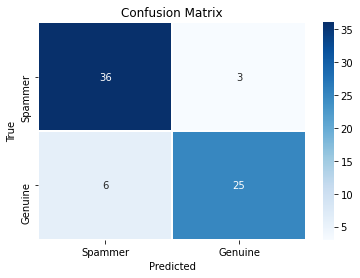

In [98]:
confusion = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion, index=labels, columns=labels)

sns.heatmap(df_cm, annot=True, linewidths=0.8, fmt='d', cmap='Blues')
plt.title('Confusion Matrix') 
plt.xlabel('Predicted')
plt.ylabel('True') 

In [99]:
print(f'False positives: ', confusion[0, 1])
print(f'False negatives: ', confusion[1, 0])

False positives:  3
False negatives:  6


### Model Metrics

In [100]:
print(f'Weighted Precision: {round(precision_score(y_true, y_pred, average="weighted") * 100, 2)}%')
print(f'Weighted Recall: {round(recall_score(y_true, y_pred, average="weighted") * 100, 2)}%')
print(f'Weighted F1-score: {round(f1_score(y_true, y_pred, average="weighted") * 100, 2)}%')

Weighted Precision: 87.3%
Weighted Recall: 87.14%
Weighted F1-score: 87.05%
